In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          12352     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4958 - acc: 0.2085
Epoch 00001: val_loss improved from inf to 2.39163, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/001-2.3916.hdf5
36805/36805 [==============================] - 29s 781us/sample - loss: 2.4958 - acc: 0.2085 - val_loss: 2.3916 - val_acc: 0.2262
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1419 - acc: 0.3522
Epoch 00002: val_loss improved from 2.39163 to 2.32499, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/002-2.3250.hdf5
36805/36805 [==============================] - 27s 730us/sample - loss: 2.1420 - acc: 0.3522 - val_loss: 2.3250 - val_acc: 0.2630
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8910 - acc: 0.4411
Epoch 00003: val_loss did not improve from 2.32499
36805/36805 [=

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2331 - acc: 0.9545
Epoch 00029: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 704us/sample - loss: 0.2331 - acc: 0.9545 - val_loss: 4.0689 - val_acc: 0.2527
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9598
Epoch 00030: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 703us/sample - loss: 0.2135 - acc: 0.9598 - val_loss: 4.1307 - val_acc: 0.2642
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9621
Epoch 00031: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 707us/sample - loss: 0.2028 - acc: 0.9621 - val_loss: 4.2280 - val_acc: 0.2548
Epoch 32/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9676
Epoch 00032: val_loss did not improve from 2.32499
36805/36805 [=====

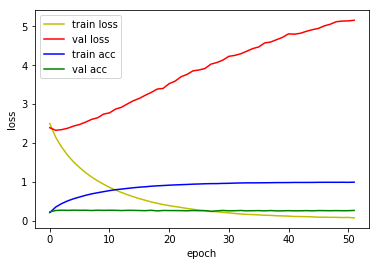

4815/4815 [==============================] - 2s 329us/sample - loss: 2.3283 - acc: 0.2569
Loss: 2.328297340337609 Accuracy: 0.2569055

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3579 - acc: 0.2581
Epoch 00001: val_loss improved from inf to 2.13599, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/001-2.1360.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.3579 - acc: 0.2580 - val_loss: 2.1360 - val_acc: 0.3403
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9674 - acc: 0.4044
Epoch 00002: val_loss improved from 2.13599 to 1.99470, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/002-1.9947.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9674 - acc: 0.4044 - val_loss: 1.9947 - val_acc: 0.3927
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7

36800/36805 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9696
Epoch 00029: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1377 - acc: 0.9697 - val_loss: 3.5233 - val_acc: 0.4027
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9719
Epoch 00030: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1262 - acc: 0.9719 - val_loss: 3.5844 - val_acc: 0.4030
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9729
Epoch 00031: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1238 - acc: 0.9729 - val_loss: 3.6415 - val_acc: 0.4011
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9756
Epoch 00032: val_loss did not improve from 1.92433
36805/36805 [========================

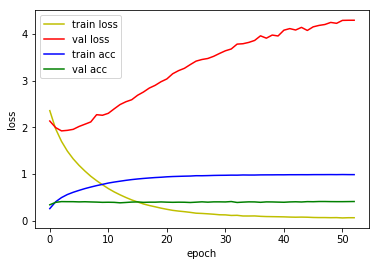

4815/4815 [==============================] - 2s 480us/sample - loss: 1.9484 - acc: 0.3961
Loss: 1.9483548640214519 Accuracy: 0.396054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2864 - acc: 0.2793
Epoch 00001: val_loss improved from inf to 1.96475, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/001-1.9647.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.2864 - acc: 0.2793 - val_loss: 1.9647 - val_acc: 0.4118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8070 - acc: 0.4499
Epoch 00002: val_loss improved from 1.96475 to 1.73310, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/002-1.7331.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8069 - acc: 0.4499 - val_loss: 1.7331 - val_acc: 0.4715
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2985 - acc: 0.9067
Epoch 00028: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2985 - acc: 0.9067 - val_loss: 2.0463 - val_acc: 0.5476
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.9120
Epoch 00029: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2812 - acc: 0.9121 - val_loss: 2.0578 - val_acc: 0.5560
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9145
Epoch 00030: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2725 - acc: 0.9145 - val_loss: 2.1180 - val_acc: 0.5504
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2536 - acc: 0.9224
Epoch 00031: val_loss did not improve from 1.61623
36805/36805 [===========


1D_CNN_3_conv_custom_conv_3_DO Model


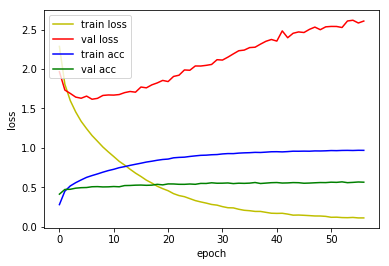

4815/4815 [==============================] - 3s 525us/sample - loss: 1.6956 - acc: 0.4795
Loss: 1.6955603861734503 Accuracy: 0.4795431

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2507 - acc: 0.2878
Epoch 00001: val_loss improved from inf to 1.85787, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/001-1.8579.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.2507 - acc: 0.2878 - val_loss: 1.8579 - val_acc: 0.4370
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6831 - acc: 0.4723
Epoch 00002: val_loss improved from 1.85787 to 1.54766, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/002-1.5477.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6831 - acc: 0.4723 - val_loss: 1.5477 - val_acc: 0.5204
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3736 - acc: 0.8817
Epoch 00026: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3736 - acc: 0.8817 - val_loss: 1.2432 - val_acc: 0.6678
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3650 - acc: 0.8828
Epoch 00027: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3651 - acc: 0.8828 - val_loss: 1.2474 - val_acc: 0.6746
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3479 - acc: 0.8873
Epoch 00028: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3479 - acc: 0.8873 - val_loss: 1.2573 - val_acc: 0.6737
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3262 - acc: 0.8942
Epoch 00029: val_loss did not improve from 1.13483
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1459 - acc: 0.9537
Epoch 00056: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1460 - acc: 0.9537 - val_loss: 1.4637 - val_acc: 0.7079
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9536
Epoch 00057: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1476 - acc: 0.9536 - val_loss: 1.4548 - val_acc: 0.7000
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1382 - acc: 0.9565
Epoch 00058: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1382 - acc: 0.9566 - val_loss: 1.5130 - val_acc: 0.7032
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9580
Epoch 00059: val_loss did not improve from 1.13483
36805/36805 [===========

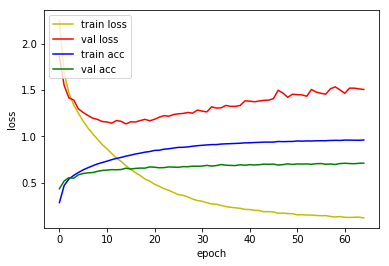

4815/4815 [==============================] - 2s 516us/sample - loss: 1.2561 - acc: 0.6278
Loss: 1.2561477027082988 Accuracy: 0.6278297

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2041 - acc: 0.2888
Epoch 00001: val_loss improved from inf to 1.76188, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/001-1.7619.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.2040 - acc: 0.2888 - val_loss: 1.7619 - val_acc: 0.4337
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5996 - acc: 0.4917
Epoch 00002: val_loss improved from 1.76188 to 1.42912, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/002-1.4291.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.5996 - acc: 0.4916 - val_loss: 1.4291 - val_acc: 0.5637
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1451 - acc: 0.9538
Epoch 00055: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1451 - acc: 0.9538 - val_loss: 1.1143 - val_acc: 0.7619
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9534
Epoch 00056: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1438 - acc: 0.9534 - val_loss: 1.1646 - val_acc: 0.7612
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9527
Epoch 00057: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1436 - acc: 0.9527 - val_loss: 1.1362 - val_acc: 0.7661
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9545
Epoch 00058: val_loss did not improve from 0.90783
36805/36805 [===========

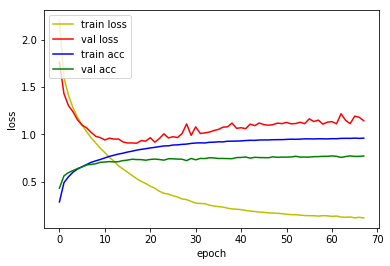

4815/4815 [==============================] - 3s 545us/sample - loss: 1.0106 - acc: 0.6941
Loss: 1.0106030552434278 Accuracy: 0.694081

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3496 - acc: 0.2289
Epoch 00001: val_loss improved from inf to 1.77711, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/001-1.7771.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.3495 - acc: 0.2289 - val_loss: 1.7771 - val_acc: 0.4300
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6689 - acc: 0.4556
Epoch 00002: val_loss improved from 1.77711 to 1.46854, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/002-1.4685.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.6688 - acc: 0.4556 - val_loss: 1.4685 - val_acc: 0.5416
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5017 - acc: 0.8472
Epoch 00024: val_loss improved from 0.61592 to 0.59190, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/024-0.5919.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5018 - acc: 0.8472 - val_loss: 0.5919 - val_acc: 0.8362
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4852 - acc: 0.8532
Epoch 00025: val_loss improved from 0.59190 to 0.56742, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/025-0.5674.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4852 - acc: 0.8532 - val_loss: 0.5674 - val_acc: 0.8404
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4674 - acc: 0.8592
Epoch 00026: val_loss did not improve from 0.56742
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4675 - acc: 0.8591 - val_loss: 0.640

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9244
Epoch 00051: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2372 - acc: 0.9244 - val_loss: 0.5493 - val_acc: 0.8614
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9235
Epoch 00052: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2419 - acc: 0.9235 - val_loss: 0.5784 - val_acc: 0.8544
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2402 - acc: 0.9224
Epoch 00053: val_loss did not improve from 0.51618
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2402 - acc: 0.9224 - val_loss: 0.5673 - val_acc: 0.8605
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9260
Epoch 00054: val_loss did not improve from 0.51618
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1580 - acc: 0.9473
Epoch 00081: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1582 - acc: 0.9473 - val_loss: 0.5936 - val_acc: 0.8616
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9492
Epoch 00082: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1498 - acc: 0.9492 - val_loss: 0.5865 - val_acc: 0.8663
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9521
Epoch 00083: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1448 - acc: 0.9521 - val_loss: 0.5384 - val_acc: 0.8775
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9532
Epoch 00084: val_loss did not improve from 0.51618
36805/36805 [===========

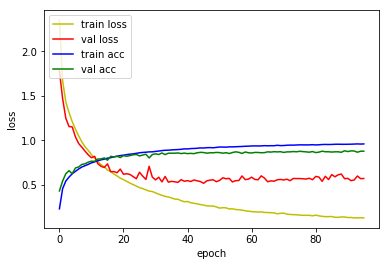

4815/4815 [==============================] - 3s 565us/sample - loss: 0.6294 - acc: 0.8299
Loss: 0.6293874348435446 Accuracy: 0.8299065

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4603 - acc: 0.1934
Epoch 00001: val_loss improved from inf to 1.85230, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/001-1.8523.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.4601 - acc: 0.1934 - val_loss: 1.8523 - val_acc: 0.4232
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7148 - acc: 0.4364
Epoch 00002: val_loss improved from 1.85230 to 1.40246, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/002-1.4025.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7149 - acc: 0.4363 - val_loss: 1.4025 - val_acc: 0.5642
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2384 - acc: 0.9231
Epoch 00049: val_loss improved from 0.27943 to 0.27730, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/049-0.2773.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2384 - acc: 0.9231 - val_loss: 0.2773 - val_acc: 0.9224
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9251
Epoch 00050: val_loss improved from 0.27730 to 0.27613, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/050-0.2761.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2377 - acc: 0.9251 - val_loss: 0.2761 - val_acc: 0.9278
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9260
Epoch 00051: val_loss did not improve from 0.27613
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2347 - acc: 0.9260 - val_loss: 0.281

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1599 - acc: 0.9462
Epoch 00077: val_loss did not improve from 0.25130
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1599 - acc: 0.9462 - val_loss: 0.2630 - val_acc: 0.9355
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9495
Epoch 00078: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1560 - acc: 0.9494 - val_loss: 0.2711 - val_acc: 0.9343
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1606 - acc: 0.9462
Epoch 00079: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1606 - acc: 0.9461 - val_loss: 0.2726 - val_acc: 0.9306
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1554 - acc: 0.9485
Epoch 00080: val_loss did not improve from 0.25130
36805/36805 [===========

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9609
Epoch 00107: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1168 - acc: 0.9609 - val_loss: 0.2827 - val_acc: 0.9352
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9598
Epoch 00108: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1175 - acc: 0.9598 - val_loss: 0.2688 - val_acc: 0.9425
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9630
Epoch 00109: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1122 - acc: 0.9630 - val_loss: 0.2933 - val_acc: 0.9336
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9618
Epoch 00110: val_loss did not improve from 0.25130
36805/36805 [=======

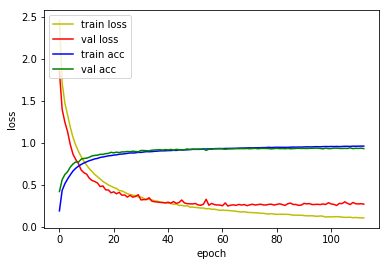

4815/4815 [==============================] - 3s 604us/sample - loss: 0.2910 - acc: 0.9153
Loss: 0.2909540087882108 Accuracy: 0.9152648

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4746 - acc: 0.1887
Epoch 00001: val_loss improved from inf to 1.71182, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/001-1.7118.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.4746 - acc: 0.1887 - val_loss: 1.7118 - val_acc: 0.4836
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6293 - acc: 0.4653
Epoch 00002: val_loss improved from 1.71182 to 1.19726, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/002-1.1973.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6294 - acc: 0.4653 - val_loss: 1.1973 - val_acc: 0.6285
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3415 - acc: 0.8927
Epoch 00024: val_loss improved from 0.25794 to 0.23135, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/024-0.2314.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3414 - acc: 0.8927 - val_loss: 0.2314 - val_acc: 0.9327
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3210 - acc: 0.8974
Epoch 00025: val_loss improved from 0.23135 to 0.22763, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/025-0.2276.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3210 - acc: 0.8974 - val_loss: 0.2276 - val_acc: 0.9315
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3131 - acc: 0.8991
Epoch 00026: val_loss improved from 0.22763 to 0.21640, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/026-0.2164.hdf5
36805/36805 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1926 - acc: 0.9367
Epoch 00050: val_loss improved from 0.17605 to 0.17587, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/050-0.1759.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1926 - acc: 0.9367 - val_loss: 0.1759 - val_acc: 0.9462
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1875 - acc: 0.9378
Epoch 00051: val_loss did not improve from 0.17587
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1874 - acc: 0.9378 - val_loss: 0.1847 - val_acc: 0.9462
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1851 - acc: 0.9395
Epoch 00052: val_loss did not improve from 0.17587
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1851 - acc: 0.9395 - val_loss: 0.1934 - val_acc: 0.9415
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9590
Epoch 00079: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1229 - acc: 0.9590 - val_loss: 0.1721 - val_acc: 0.9515
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9599
Epoch 00080: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1188 - acc: 0.9599 - val_loss: 0.1791 - val_acc: 0.9518
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9620
Epoch 00081: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1138 - acc: 0.9620 - val_loss: 0.1662 - val_acc: 0.9532
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9604
Epoch 00082: val_loss did not improve from 0.15928
36805/36805 [===========

Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9797
Epoch 00138: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0586 - acc: 0.9797 - val_loss: 0.1890 - val_acc: 0.9543
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9795
Epoch 00139: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0612 - acc: 0.9795 - val_loss: 0.1957 - val_acc: 0.9560
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9804
Epoch 00140: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0591 - acc: 0.9804 - val_loss: 0.1899 - val_acc: 0.9574
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9799
Epoch 00141: val_loss did not improve from 0.15633
36805/36805 [=======

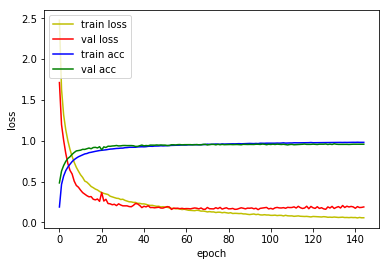

4815/4815 [==============================] - 3s 545us/sample - loss: 0.1899 - acc: 0.9443
Loss: 0.18985166766933192 Accuracy: 0.9443406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2601 - acc: 0.2634
Epoch 00001: val_loss improved from inf to 1.43353, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/001-1.4335.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.2600 - acc: 0.2635 - val_loss: 1.4335 - val_acc: 0.5563
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3645 - acc: 0.5537
Epoch 00002: val_loss improved from 1.43353 to 0.93191, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/002-0.9319.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.3646 - acc: 0.5536 - val_loss: 0.9319 - val_acc: 0.7205
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9305
Epoch 00024: val_loss improved from 0.19252 to 0.19247, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/024-0.1925.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2147 - acc: 0.9305 - val_loss: 0.1925 - val_acc: 0.9404
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9319
Epoch 00025: val_loss improved from 0.19247 to 0.17917, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/025-0.1792.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2083 - acc: 0.9319 - val_loss: 0.1792 - val_acc: 0.9446
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9361
Epoch 00026: val_loss improved from 0.17917 to 0.17511, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/026-0.1751.hdf5
36805/36805 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9656
Epoch 00050: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1010 - acc: 0.9656 - val_loss: 0.1719 - val_acc: 0.9536
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0944 - acc: 0.9677
Epoch 00051: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0944 - acc: 0.9677 - val_loss: 0.1719 - val_acc: 0.9504
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 0.9662
Epoch 00052: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0985 - acc: 0.9662 - val_loss: 0.1682 - val_acc: 0.9539
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9691
Epoch 00053: val_loss did not improve from 0.15192
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9818
Epoch 00080: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0518 - acc: 0.9819 - val_loss: 0.1831 - val_acc: 0.9583
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9830
Epoch 00081: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0517 - acc: 0.9830 - val_loss: 0.1747 - val_acc: 0.9567
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9831
Epoch 00082: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0489 - acc: 0.9831 - val_loss: 0.1931 - val_acc: 0.9560
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9830
Epoch 00083: val_loss did not improve from 0.15192
36805/36805 [===========

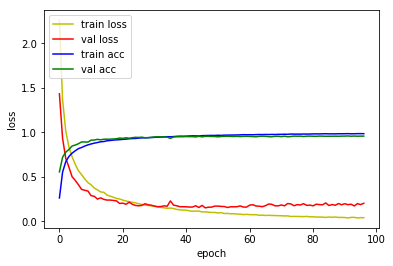

4815/4815 [==============================] - 3s 641us/sample - loss: 0.1995 - acc: 0.9402
Loss: 0.19947422533948844 Accuracy: 0.9401869



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 390us/sample - loss: 2.3283 - acc: 0.2569
Loss: 2.328297340337609 Accuracy: 0.2569055

1D_CNN_2_conv_custom_conv_3_DO Model
____________________________________________________

4815/4815 [==============================] - 3s 646us/sample - loss: 0.6294 - acc: 0.8299
Loss: 0.6293874348435446 Accuracy: 0.8299065

1D_CNN_7_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None,

4815/4815 [==============================] - 3s 707us/sample - loss: 0.1995 - acc: 0.9402
Loss: 0.19947422533948844 Accuracy: 0.9401869
